In [2]:
%pylab inline

from sklearn.datasets import fetch_openml

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.layers import LeakyReLU, Dropout, ReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop

from tqdm._tqdm_notebook import tqdm_notebook

rcParams['axes.grid'] = True
rcParams['figure.figsize'] = (10,6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
mnist = fetch_openml('mnist_784',version=1)
X, y = mnist['data'], mnist['target'].astype(int)
X_train = X.reshape(X.shape[0],28,28,1)/255

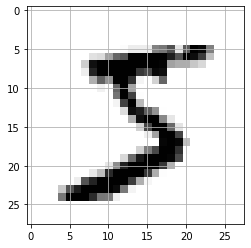

In [4]:
imshow(X_train[0].reshape(28,28)*255,cmap='binary')

In [185]:
def discriminator():
    
    net = Sequential()
    input_shape = (28, 28, 1)
    dropout_prob = 0.4

    net.add(Conv2D(64, 5, strides=2, input_shape=input_shape, padding='same'))
    net.add(LeakyReLU())
    
    net.add(Conv2D(128, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(256, 5, strides=2, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Conv2D(512, 5, strides=1, padding='same'))
    net.add(LeakyReLU())
    net.add(Dropout(dropout_prob))
    
    net.add(Flatten())
    net.add(Dense(1))
    net.add(Activation('sigmoid'))
    
    return net
    
def generator():
    net = Sequential()
    dropout_prob = 0.4

    net.add(Dense(7*7*256, input_dim=100))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    net.add(Reshape((7,7,256)))
    net.add(Dropout(dropout_prob))
    
    net.add(UpSampling2D())
    net.add(Conv2D(128, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(UpSampling2D())
    net.add(Conv2D(64, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(32, 5, padding='same'))
    net.add(BatchNormalization(momentum=0.9))
    net.add(LeakyReLU())
    
    net.add(Conv2D(1, 5, padding='same'))
    net.add(Activation('sigmoid'))
    
    return net

In [186]:
net_discriminator = discriminator()
net_discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)         0

In [187]:
net_generator = generator()
net_generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)      

In [188]:
net_discriminator.load_weights('mnist-gan/v1_dis.h5')
net_generator.load_weights('mnist-gan/v1_gen.h5')

In [189]:
dis_lr=0.0008
dis_clipvalue=1.0
dis_decay=1e-10
dis_optimizer = RMSprop

optim_discriminator = RMSprop(lr=dis_lr, clipvalue=dis_clipvalue, decay=dis_decay)
model_discriminator = Sequential()
model_discriminator.add(net_discriminator)
model_discriminator.compile(loss='binary_crossentropy', optimizer=optim_discriminator, metrics=['accuracy'])

model_discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 1)                 4311553   
Total params: 4,311,553
Trainable params: 4,311,553
Non-trainable params: 0
_________________________________________________________________


In [190]:
adv_lr=0.0004
adv_clipvalue=1.0
adv_decay=1e-10
adv_optimizer = Adam

optim_adversarial = Adam(lr=adv_lr, clipvalue=adv_clipvalue, decay=adv_decay)
model_adversarial = Sequential()
model_adversarial.add(net_generator)

# Disable layers in discriminator
for layer in net_discriminator.layers:
    layer.trainable = False
model_adversarial.add(net_discriminator)
model_adversarial.compile(loss='binary_crossentropy', optimizer=optim_adversarial, metrics=['accuracy'])
model_adversarial.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         2394241   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 4311553   
Total params: 6,705,794
Trainable params: 2,368,705
Non-trainable params: 4,337,089
_________________________________________________________________


In [191]:
batch_size = 256

vis_noise = np.random.uniform(-1.0, 1.0, size=[16, 100])

stats = []
rounds = 0 

def train(steps=100):
    global rounds
    for step in tqdm_notebook(range(steps)):
        rounds += 1
        # Select a random set of training images from the mnist dataset
        images_train = X_train[np.random.randint(0, X_train.shape[0], size=batch_size), :, :, :]
        # Generate a random noise vector
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        # Use the generator to create fake images from the noise vector
        images_fake = net_generator.predict(noise)

        # Create a dataset with fake and real images
        x = np.concatenate((images_train, images_fake))
        y = np.ones([2*batch_size, 1])
        y[batch_size:, :] = 0 

        # Train discriminator for one batch
        d_stats = model_discriminator.train_on_batch(x, y)
        
        # Train the generator
        # The input of the adversarial model is a list of noise vectors
        # The generator is 'good' if the discriminator classifies all the generated images as real
        # Therefore, the desired output is a list of all ones
        y = np.ones([batch_size, 1])
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
        a_stats = model_adversarial.train_on_batch(noise, y)

        if rounds % 50 == 0:
            stats.append([d_stats,a_stats])

        if rounds % 100 == 0:
            # Visualize the performance of the generator by producing images from the test vector
            images = net_generator.predict(vis_noise)
            # Map back to original range
            #images = (images + 1 ) * 0.5
            plt.figure(figsize=(10,10))

            for im in range(images.shape[0]):
                plt.subplot(4, 4, im+1)
                image = images[im, :, :, :]
                image = np.reshape(image, [28, 28])

                plt.imshow(image, cmap='gray')
                plt.axis('off')

            plt.tight_layout()
            plt.savefig('mnist-gan/v2_{}.png'.format(rounds))
            plt.close('all')

In [192]:
train(5)

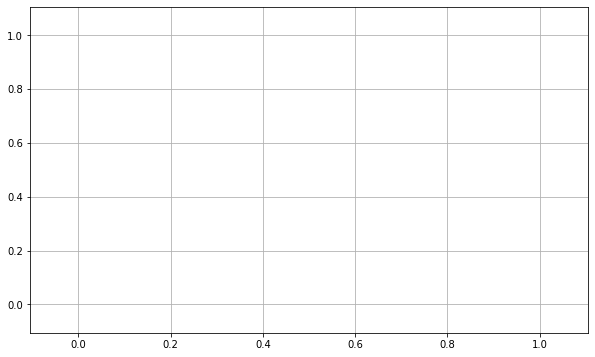

In [182]:
plot([d[0][1] for d in stats],label='discriminator loss')
plot([a[1][1] for a in stats],label='adversarial loss')

In [140]:
net_generator.save('mnist-gan/v1_gen.h5')
net_discriminator.save('mnist-gan/v1_dis.h5')

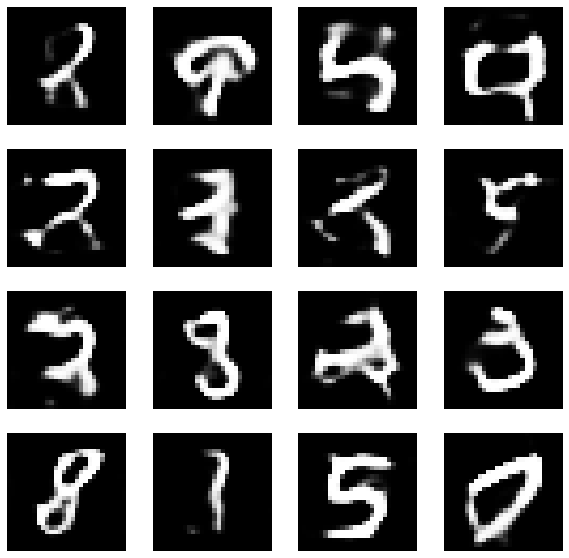

In [193]:
images = net_generator.predict(vis_noise)
# Map back to original range
#images = (images + 1 ) * 0.5
plt.figure(figsize=(10,10))

for im in range(images.shape[0]):
    plt.subplot(4, 4, im+1)
    image = images[im, :, :, :]
    image = np.reshape(image, [28, 28])

    plt.imshow(image, cmap='gray')
    plt.axis('off')